In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install PyPDF2
!pip install transformers
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
import PyPDF2 
import re
from PyPDF2 import PdfReader
import json
from transformers import AutoTokenizer
from transformers import BertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
import spacy
import xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
def tokenize_parrafos(data):
    return tokenizer(Datos_Parrafos["Parrafo"], padding="max_length", truncation=True)

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [ ]:
datos_parrafos="/content/drive/Shareddrives/Proyecto PNL/Proyecto PLN 20221125/Proyecto PLN 2022-2/sentencias/Clasificación de Parrafos/Parrafos CD y EA.xlsx"

In [ ]:
Datos_Parrafos=pd.read_excel(datos_parrafos)

In [ ]:
def contar(x):
  y=x.split(" ")  
  return len(y)

cuentapalabras=Datos_Parrafos["Parrafo"].apply(lambda x:contar(x))
cuentapalabras.max()


682

In [ ]:
Datos_Parrafos.sample(10)
#len(Datos_Parrafos)

,Radicado,ID Categoria,No. Parrafo,Parrafo,Categoria
1526,20001312100220170006000,2,146,"Con base en lo anterior, se expide la Ley 1448...",Fundamentos de Derecho
52,86001312100120200017500,1,34,"245657\n0° 18' 0,972""\nN\n77° 0' 13,777""\nW\n5...",Antecedentes de hecho y hechos probados
1756,05000312100120190006200,2,70,Dada la magnitud del fenómeno del desplazamien...,Fundamentos de Derecho
2128,73001312100120180003201,2,198,Para que el opositor pueda válidamente alegar ...,Fundamentos de Derecho
406,76001312100320200008000,1,37,Se destaca la relación existente entre la vers...,Antecedentes de hecho y hechos probados
1113,23001312100120190014701,1,206,"Justamente, para nadie era un secreto que en l...",Antecedentes de hecho y hechos probados
521,86001312140220180000700,1,32,¿Tiene derecho la solicitante a que el juzgado...,Antecedentes de hecho y hechos probados
1736,05000312100120190006200,2,50,De conformidad con los artículos 795 y 80 ejus...,Fundamentos de Derecho
2143,73001312100120180003201,2,213,“Reducir al mínimo los impactos negativos cons...,Fundamentos de Derecho
456,76001312100320200008000,2,63,"Así las cosas, se ordenará a la UNIDAD ADMINIS...",Fundamentos de Derecho


#**RECODIFICACIÓN**

In [ ]:
def categoria(old_label):
  new_label = None
  if old_label in ["Antecedentes de hecho y hechos probados", "Fundamentos de Derecho"]:
    new_label = 0
  if old_label == "Encabezamiento":
    new_label = 1
  if old_label == "Parte dispositiva y fallo":
    new_label = 2
  return(new_label)


In [ ]:
# carga de datos
datos = pd.read_excel(datos_parrafos, sheet_name = "Datos", dtype = {"Radicado": "string", "Categoria": "category"})
datos["label"] = datos["Categoria"].apply(lambda x: categoria(x)).astype("category")
datos["Parrafo"] = datos["Parrafo"].apply(lambda x: re.sub("\s{2,}", " ", x)).str.strip()
datos.dtypes

Radicado          string
ID Categoria       int64
No. Parrafo        int64
Parrafo           object
Categoria       category
label           category
dtype: object

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
spanish_stopwords = stopwords.words('spanish')

# **DIVISIÓN EN CONJUNTO DE ENTRENAMIENTO Y PRUEBA**


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
res = train_test_split(datos["Parrafo"],  datos["label"],
                       train_size=0.8,
                       test_size=0.2,
                       random_state=42)
train_data, test_data, train_targets,test_targets=res

#**CLASIFICADOR NAIVE BAYES**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
vectorizer = CountVectorizer(stop_words=spanish_stopwords)

In [ ]:
vectors = vectorizer.fit_transform(train_data)

In [ ]:
classifier = MultinomialNB(alpha=.01)
modeloNB=classifier.fit(vectors, train_targets)

vectors_test = vectorizer.transform(test_data)

predictions = classifier.predict(vectors_test)
accuracy_score = metrics.accuracy_score(test_targets, 
                                        predictions)
f1_score = metrics.f1_score(test_targets, 
                            predictions, 
                            average='macro')

print("accuracy score: ", accuracy_score)
print("F1-score: ", f1_score)

accuracy score:  0.8806941431670282
F1-score:  0.7377023853664566


In [ ]:
from sklearn.metrics import confusion_matrix
CM=confusion_matrix(predictions,test_targets)

In [ ]:
CMSuma=CM.sum(axis=1)
CMSuma.shape=(3,1)
CM_porcentaje=CM/CMSuma

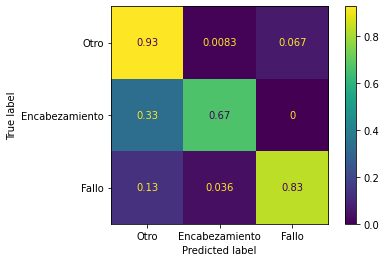

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = CM_porcentaje, display_labels = ["Otro","Encabezamiento", "Fallo"])

cm_display.plot()
plt.show()

#**CLASIFICADOR MLP**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn import metrics

vectorizer2 = CountVectorizer(stop_words=spanish_stopwords)
vectors2 = vectorizer.fit_transform(train_data)

print("Creating a classifier. This will take some time!")
classifier = MLPClassifier(random_state=1, max_iter=300).fit(vectors2, train_targets)

Creating a classifier. This will take some time!


In [ ]:
vectors_test = vectorizer.transform(test_data)

predictions = classifier.predict(vectors_test)
accuracy_score = metrics.accuracy_score(test_targets, 
                                        predictions)
f1_score = metrics.f1_score(test_targets, 
                            predictions, 
                            average='macro')

print("accuracy score: ", accuracy_score)
print("F1-score: ", f1_score)

accuracy score:  0.8980477223427332
F1-score:  0.7962619149238868


In [ ]:
CM2=confusion_matrix(predictions,test_targets)
CM2Suma=CM2.sum(axis=1)
CM2Suma.shape=(3,1)
CM2_porcentaje=CM2/CM2Suma

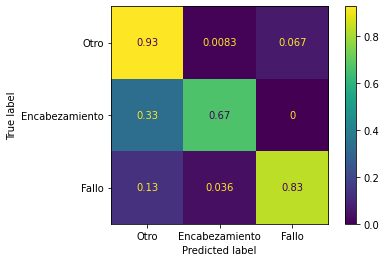

In [ ]:
cm2_display = metrics.ConfusionMatrixDisplay(confusion_matrix = CM2_porcentaje, display_labels = ["Otro","Encabezamiento", "Fallo"])

cm_display.plot()
plt.show()